# Feature Engineering

## Setup

### Import modules

In [3]:
# Data manipulation

import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

import numpy as np
import re
import sklearn 

# NLP

import textdistance as td
from sklearn.feature_extraction.text import CountVectorizer

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Plotting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

# Miscellaneous

import rootpath
import glob

### Locate files

In [4]:
# Set root path for project

rpath = rootpath.detect()

### Compile data

In [5]:
df_products = pd.read_csv(f"{rpath}/data/clean/data_clean.csv", index_col=0)

In [6]:
df_products.head()

,product_type,brand_generic,brand,product,size,price,details,og_ingred,ratings,perc_respondrec,total_reviews,link,page,use_category,ingred_len,ingred_rev
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,water,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,5,water
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,solum diatomeae/diatomaceous earth/terre de di...,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,53,solum diatomeae/diatomaceous earth/terre de di...
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,glycerin,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,8,glycerin
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates/steareth-20 methacrylate copolymer,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,44,acrylates/steareth-20 methacrylate copolymer
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates copolymer,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,19,acrylates copolymer


In [7]:
df_products.product_type.unique()

array(['face wash', 'face moisturizer', 'toner', 'face serum',
       'toothpaste'], dtype=object)

In [8]:
df_products.brand_generic.unique()

array(['non_generic', 'Aveeno_generic', 'CC_generic', 'StIves_generic',
       'BB_generic', 'Cetaphil_cream_generic',
       'Cetaphil_cleanser_generic'], dtype=object)

In [9]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22587 entries, 0 to 20
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_type     22587 non-null  object 
 1   brand_generic    22587 non-null  object 
 2   brand            22587 non-null  object 
 3   product          22587 non-null  object 
 4   size             22227 non-null  float64
 5   price            22227 non-null  float64
 6   details          22520 non-null  object 
 7   og_ingred        22587 non-null  object 
 8   ratings          20080 non-null  float64
 9   perc_respondrec  7936 non-null   object 
 10  total_reviews    20309 non-null  float64
 11  link             22587 non-null  object 
 12  page             22520 non-null  float64
 13  use_category     22520 non-null  object 
 14  ingred_len       22587 non-null  int64  
 15  ingred_rev       22587 non-null  object 
dtypes: float64(5), int64(1), object(10)
memory usage: 2.9+ MB


## Train test split
- Need to do a grouped split in order to preserve ingredient associations with each product since each row of df is an ingredient 
- Need a stratified split to ensure equal proportion of product types in train and test sets
- Have to aggregate df ingredients by product into lists before split to avoid ingredients associated with a product being split between training and test set (data leakage) since the same product could be in both data sets

**Aggregate data for train test split**

In [10]:
# Aggregate ingredients into lists by product

df_prod_agg = (
    df_products.groupby('product', as_index=False).agg({'ingred_rev':lambda x: list(x)})
)

In [11]:
df_prod_agg.shape

(969, 2)

In [12]:
df_prod_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 968
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product     969 non-null    object
 1   ingred_rev  969 non-null    object
dtypes: object(2)
memory usage: 22.7+ KB


In [13]:
# Merge original df on aggregated dataframe to get rest of product information
# Remove product duplicates

df_prod_agg = df_prod_agg.merge(
    df_products.drop('ingred_rev', axis=1), on='product', how='left'
    ) \
    .drop_duplicates(subset=['product'], ignore_index=True) 

In [14]:
df_prod_agg.shape

(969, 16)

In [15]:
df_prod_agg.head()

,product,ingred_rev,product_type,brand_generic,brand,size,price,details,og_ingred,ratings,perc_respondrec,total_reviews,link,page,use_category,ingred_len
0,''Buffet'',"[water, glycerin, lactococcus ferment lysate, ...",face serum,non_generic,The Ordinary,1.0,14.8,''Buffet'' from The Ordinary combines a compre...,water,4.4,NaN,333.0,https://www.ulta.com/buffet?productId=pimprod2...,1.0,treatments and serums,5
1,''Buffet'' + Copper Peptides 1%,"[water, glycerin, lactococcus ferment lysate, ...",face serum,non_generic,The Ordinary,1.0,28.9,''Buffet'' + Copper Peptides 1% from The Ordin...,water,4.3,NaN,52.0,https://www.ulta.com/buffet-copper-peptides-1?...,1.0,treatments and serums,5
2,+Retinol Vita C Power Serum Firming + Brighten...,"[retinol, water, dimethicone, propanediol, pol...",face serum,non_generic,Kate Somerville,1.0,98.0,Uniquely formulated with the gold standards in...,retinol,4.3,NaN,47.0,https://www.ulta.com/retinol-vita-c-power-seru...,1.0,treatments and serums,7
3,+Retinol Vitamin C Moisturizer,"[water, neopentyl glycol dicaprylate/dicaprate...",face moisturizer,non_generic,Kate Somerville,1.7,90.0,Packed with anti-aging powerhouses Retinol and...,water,3.7,NaN,10.0,https://www.ulta.com/retinol-vitamin-c-moistur...,2.0,moisturizer,5
4,100% Plant-Derived Squalane,[ecocert approved],face serum,non_generic,The Ordinary,1.0,7.9,100% Plant-Derived Squalane from The Ordinary ...,ecocert approved,4.5,NaN,192.0,https://www.ulta.com/100-plant-derived-squalan...,1.0,treatments and serums,16


**Check class imbalance in product type and ground truth labels**

<AxesSubplot:title={'center':'Relative class frequencies for product types'}>

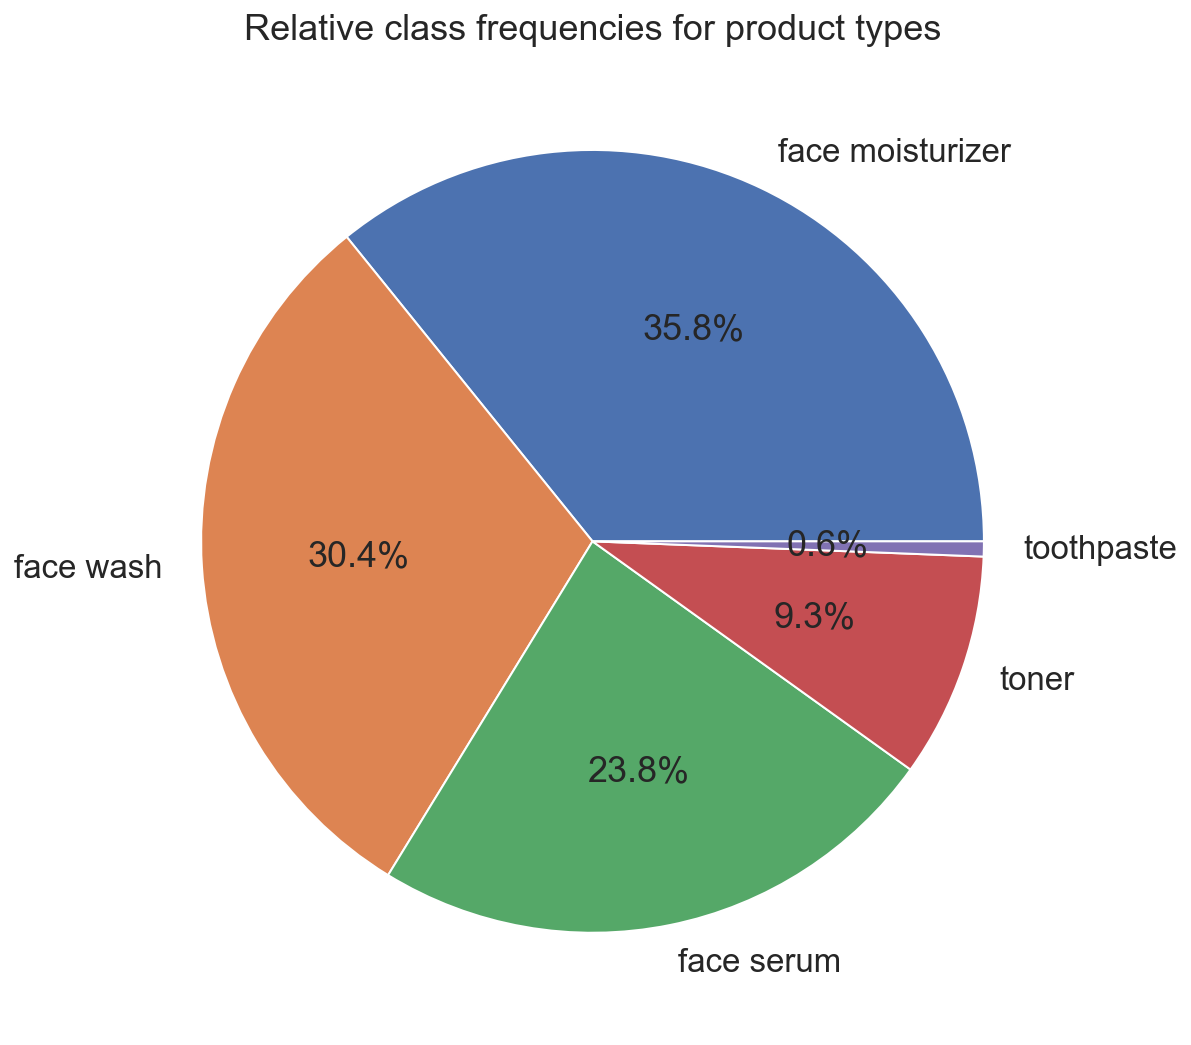

In [16]:
df_prod_agg['product_type'] \
            .value_counts() \
            .plot.pie(autopct='%1.1f%%',
                      title='Relative class frequencies for product types',
                      ylabel='')

- Some imbalance, particularly in face serum and toner relative to face wash and face moisturizer and the toothpaste control

<AxesSubplot:title={'center':'Relative class frequencies for ground truth labels'}>

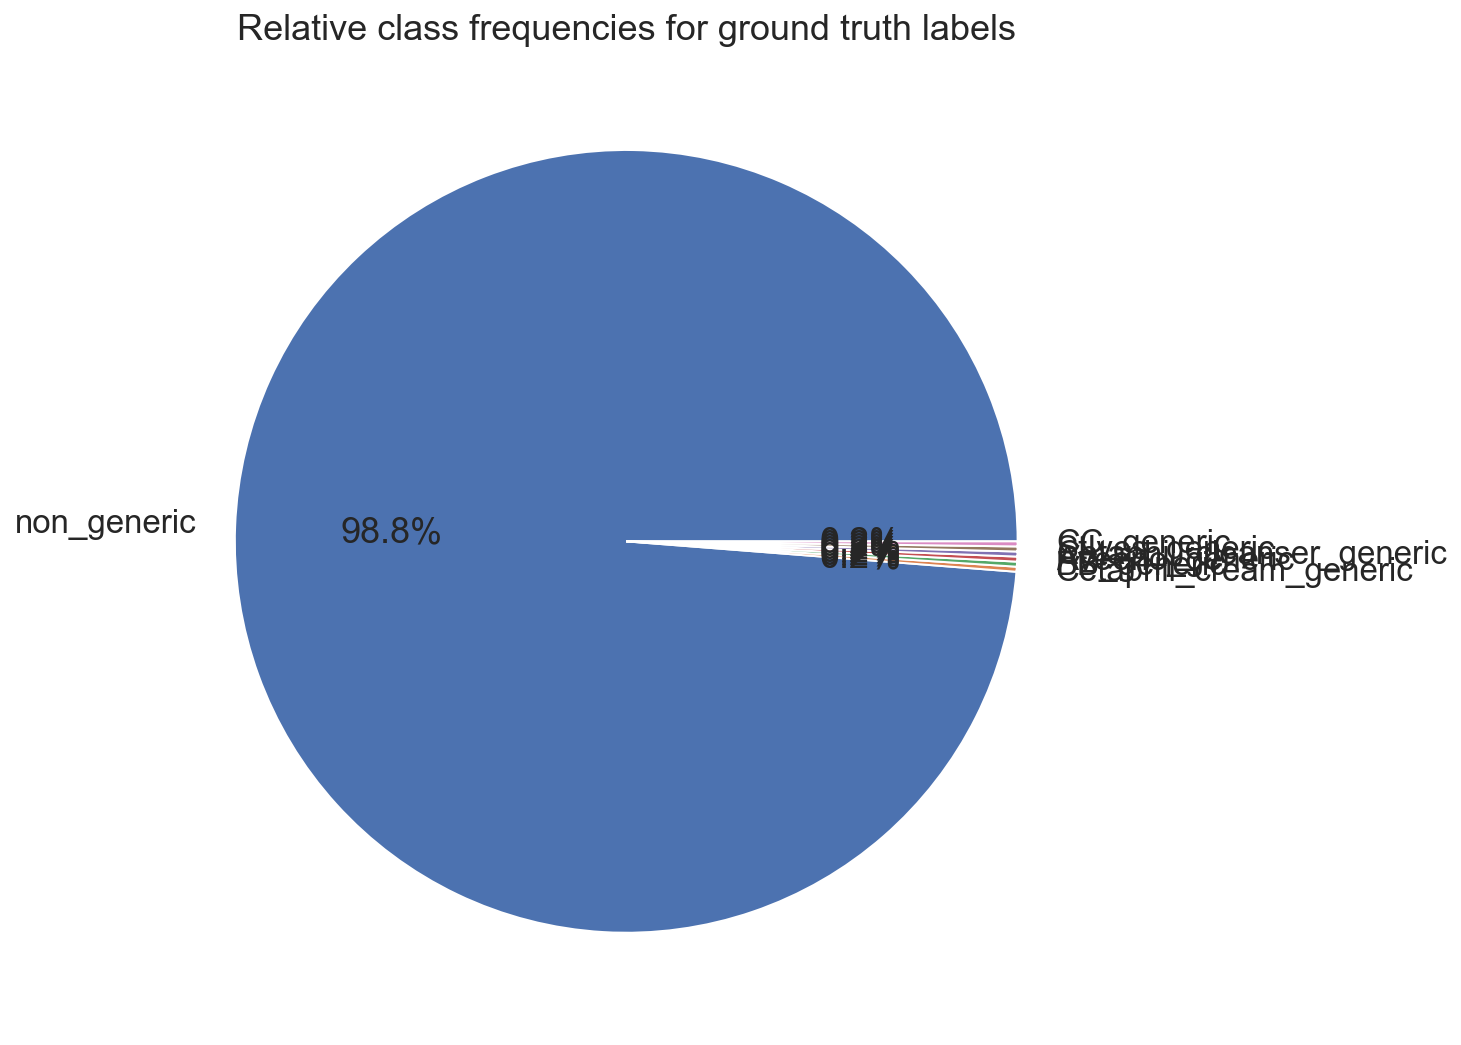

In [17]:
df_prod_agg['brand_generic'] \
            .value_counts() \
            .plot \
            .pie(autopct='%1.1f%%',
                 title='Relative class frequencies for ground truth labels',
                 ylabel='')

**Pivot df from long to wide for ingredients as columns**

In [18]:
# Expand ingredient lists per product to a 
# row for each ingredient with repeated rows
# for each product

df_ingred = df_prod_agg.explode('ingred_rev')

**Convert long df to wide with ingredients as the columns**

In [19]:
# Create a column of 1's for the values to indicate presence of an ingredient

df_ingred['fill_value'] = 1

In [20]:
pivot_indices = (
   ['product','use_category','product_type','brand_generic',
    'brand','size','price','ratings','total_reviews',
    'link']
)

In [21]:
# Fill NAs with "blank" text
# Can't do dropna=False b/c of a memory issue
# NaNs in some of the non-relevant columns of the brand_generics
# So those get dropped from pivoting if NaNs aren't replaced

df_ingred = df_ingred.fillna("blank")

In [22]:
# Pivot table from long to wide 

ingred_counts = pd.pivot_table(df_ingred, values='fill_value',
                                 index=pivot_indices, 
                                 columns='ingred_rev',
                                 fill_value=0,
                                 aggfunc=np.sum,
                                 dropna=True) \
                  .reset_index()       

In [23]:
# Rename column name index to none

ingred_counts.columns.names = [None]

**Split training and test sets using stratification for class imbalance**

In [24]:
# Function to return training and test set splits 

def get_train_test(target, df, test_size=0.2):
    '''
    Purpose: Return train and test set splits based on the target variable and
    data frame. Since the target is categorical in this case, splits are
    stratified. 
    
    target: the string name of the dataframe column with the target variable
    df: a pandas dataframe holding the features
    '''
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = (
        train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    )
    return X_train, X_test, y_train, y_test

In [25]:
# Split into train and test for prod type

X_train_prodtype, X_test_prodtype, y_train_prodtype, y_test_prodtype = (
    get_train_test('product_type', ingred_counts)
)

In [26]:
# Check class proportions are equal in train and test set

print('Training set relative class frequencies')
y_train_prodtype.value_counts()/len(y_train_prodtype)

Training set relative class frequencies


face moisturizer    0.357419
face wash           0.304516
face serum          0.238710
toner               0.092903
toothpaste          0.006452
Name: product_type, dtype: float64

In [27]:
print('Test set relative class frequencies')
y_test_prodtype.value_counts()/len(y_test_prodtype)

Test set relative class frequencies


face moisturizer    0.360825
face wash           0.304124
face serum          0.237113
toner               0.092784
toothpaste          0.005155
Name: product_type, dtype: float64

In [28]:
# Split into train and test for generic labels
# Note test size is 0.5 because there are so few instances of each class!
# Otherwise, for smaller test sizes, we don't get one of each class
# instance in both the training and the test sets

X_train_brandgen, X_test_brandgen, y_train_brandgen, y_test_brandgen = (
    get_train_test('brand_generic', ingred_counts, test_size=0.5)
)

In [29]:
X_train_brandgen.shape

(484, 1642)

In [30]:
X_test_brandgen.shape

(485, 1642)

In [31]:
# Check class proportions are equal in train and test set

print('Training set relative class frequencies')
y_train_brandgen.value_counts()/len(y_train_brandgen)

Training set relative class frequencies


non_generic                  0.987603
BB_generic                   0.002066
Cetaphil_cream_generic       0.002066
Cetaphil_cleanser_generic    0.002066
Aveeno_generic               0.002066
StIves_generic               0.002066
CC_generic                   0.002066
Name: brand_generic, dtype: float64

In [32]:
print('Test set relative class frequencies')
y_test_brandgen.value_counts()/len(y_test_brandgen)

Test set relative class frequencies


non_generic                  0.987629
Aveeno_generic               0.002062
Cetaphil_cleanser_generic    0.002062
Cetaphil_cream_generic       0.002062
StIves_generic               0.002062
BB_generic                   0.002062
CC_generic                   0.002062
Name: brand_generic, dtype: float64

In [33]:
y_train_brandgen.head()

458    non_generic
420    non_generic
449    non_generic
295    non_generic
807    non_generic
Name: brand_generic, dtype: object

## TF-IDF 

- Need to create term frequency matrix grouped by product 
- Can't use the sklearn TF-IDF vectorizer because of the long format, e.g. multiple rows of ingredients for each product since it will read each ingredient product combination as a separate product

**Transform term frequency matrix to idf**

In [34]:
# Get product info columns without product

prod_info = [string for string in pivot_indices if string != 'product']

In [36]:
def filter_string(list_of_strings, string_to_remove):
    """
    Purpose: filters a string(s) from a list of strings
    Returns: a list without the indicated string(s)
    string_to_remove: MUST BE A LIST
    """
    new_list = [string for string in list_of_strings \
                    if string not in string_to_remove]
    return new_list

In [37]:
def get_prod_info(df, col_to_remove=[]):
    """
    Purpose: returns ingredient col names and product row names from df 
        to be assigned to tf-idf df
    col_to_remove: list, columns in prod info that are not present in the
        df and need to be removed from prod info since they are not present
        in that df. 
    """
    # Extract ingredient col names
    ingred_cols = df.drop(col_to_remove,
                               axis=1).columns.values
    # Extract product row names
    prod_names = df['product'].values
    return ingred_cols, prod_names

In [38]:
# get column and product names for tf-idf dataframe

brandgen_ingred_names, brandgen_prod_names = (
    get_prod_info(ingred_counts, col_to_remove=prod_info)
)

X_train_brandgen_ingred_names, X_train_brandgen_prod_names = (
    get_prod_info(X_train_brandgen,
                  col_to_remove=filter_string(prod_info,['brand_generic']))
)

X_test_brandgen_ingred_names, X_test_brandgen_prod_names = (
    get_prod_info(X_test_brandgen,
                  col_to_remove=filter_string(prod_info,['brand_generic']))
)

In [39]:
def get_tf(df, col_to_keep):
    """
    Purpose: Get term frequencies from dataframe
    Returns the tf matrix (not df!)
    col_to_keep: List of strings. These should be ingredient column names.
    """
    # Select columns with product name and ingredients only
    # This removes the other columns, e.g. product info 
    df = df[df.columns.intersection(col_to_keep)].set_index(keys='product')
    # convert df to tf matrix
    ingred_tf = df.to_numpy()
    return ingred_tf

**Calculate IDF values for frequency matrix**

In [40]:
def reorder_first_cols(df, col_order):
    '''
    Reorder columns in dataframe with col_order as a list of column names
    in the order you want them in to appear at the beginner of the dataframe.
    The rest of the columns will remain in the same order as before. 
    '''
    # Create new column ordering
    new_col_order = (
          col_order + [col for col in df.columns if col not in col_order]
    )
    # Reindex columns based on new order
    df = df.reindex(columns=new_col_order)
    
    return df

In [41]:
def get_idf(tf_matrix, col_names, prod_names):
    """
    Purpose: Get idf values from matrix of term frequencies.
    Returns df of tf-idf values
    tf_matrix: Term frequency matrix from get_tf() above
    col_names: List of column names for tf_matrix used when constructing df
    prod_names: List of row names for products in the tf-idf df when 
        constructing the tf-idf df
    """
    # Import tfidf transformer
    from sklearn.feature_extraction.text import TfidfTransformer
    # Set transformer arguments 
    transformer = TfidfTransformer(norm='l2',
                               use_idf=True, smooth_idf=True,
                               sublinear_tf=True)
    # Get the TF-IDF weighted ingredient matrix
    tfidf_res = transformer.fit_transform(tf_matrix)
    # Convert to df
    df_tf_idf = pd.DataFrame(tfidf_res.toarray())
    # Add ingredient column names
    df_tf_idf.columns = col_names
    # add product names to df
    df_tf_idf['product'] = prod_names
    # Re-order columns with product being first
    df_tf_idf = reorder_first_cols(df_tf_idf, ['product'])
    return df_tf_idf

In [42]:
def get_tf_idf(df, col_names, prod_names):
    """
    Purpose: get tf-idf matrix from a frequency count table and convert to a
    pandas df. Return the df.
    """
    # Get term frequency matrix for ingredients for brand generic
    ingred_tf = get_tf(df, col_to_keep=col_names)
    # Get idf values 
    df_tf_idf = get_idf(ingred_tf, 
                        col_names=filter_string(col_names, 'product'),  
                        prod_names=prod_names)
    return df_tf_idf

In [43]:
# Get tf-idf values

df_tf_idf = get_tf_idf(ingred_counts,
                       brandgen_ingred_names, 
                       brandgen_prod_names)

df_train_tf_idf = get_tf_idf(X_train_brandgen,
                             X_train_brandgen_ingred_names,
                             X_train_brandgen_prod_names)

df_test_tf_idf = get_tf_idf(X_test_brandgen,
                            X_test_brandgen_ingred_names,
                            X_test_brandgen_prod_names)

## Ingredient weighting 

### Ordinal encoding

### Ordinal encoding for ingredients

In [44]:
# Get unique products in df

prod_original = ingred_counts['product'].values
prod_train = X_train_brandgen['product'].values
prod_test = X_test_brandgen['product'].values

In [45]:
# Subset original long ingredient df for only products in the training set

df_original_ingred = df_ingred.query('product in @prod_original').copy()
df_train_ingred = df_ingred.query('product in @prod_train').copy()
df_test_ingred = df_ingred.query('product in @prod_test').copy()

In [46]:
def add_ord(df):
    """
    Purpose: Create new column with ordinal encodings for ingredient 
    order within each product 
    Returns: dataframe with ordinal encodings
    """
    # Create temporary placeholder constant for ordering
    df['ingred_value'] = 1
    # Add order numbering for ingredients within each product
    df['ingred_order'] = (
        df.groupby('product')['ingred_value'] \
                 .rank(method="first")
    )
    # Count total number of ingredients per product and expand 
    # result into main df
    df = df.assign(
        total_ingred = df.groupby('product')['ingred_order'] \
                                .transform('max')
    )
    # Take difference of ordinal max from ingredient order to get ordinal
    # values for ingredients in decreasing order
    # Add 1 so that the ingredient with the smallest concentration is
    # 1 and not 0 (because 0 would mean it is not present)
    df['ingred_ordinal'] = (
        (df["total_ingred"] - df["ingred_order"])+1
    )
    return df

In [47]:
# Add ordinal weighting to ingredients

df_orginal_ingred_ord = add_ord(df_original_ingred)
df_train_ingred_ord = add_ord(df_train_ingred)
df_test_ingred_ord = add_ord(df_test_ingred)

In [48]:
def scale_ord(df):
    """
    Scale by the number of ingredients in the product so products with 
    different numbers of ingredients are on the same scale
    Minus 1 because added 1 before so last ingredient would not be zero
    """
    df['ingred_ordinal_sc'] = (
        df['ingred_ordinal']/(df["total_ingred"])
    )
    return df

In [49]:
# Scale ordinal encodings

df_orginal_ingred_ord_sc = scale_ord(df_orginal_ingred_ord)
df_train_ingred_ord_sc = scale_ord(df_train_ingred_ord)
df_test_ingred_ord_sc = scale_ord(df_test_ingred_ord)

In [57]:
def add_ord_wts(df_ord_wts, df_tf_idf, df_ingred, add_prodtype=False):
    """
    Purpose: Multiplies scaled ordinal encodings to tf-idf 
    for ingredient values
    Returns: df
    df_ord_wts: df of ingredients with ordinal weightings that
        are also scaled
    df_tf_idf: tf_idf df
    add_prodtype: add product_type to prod info. 
    """
    # Convert ordinal weights df from long to wide 
    # with ingredients as the columns and 
    # products as the rows
    df_ingred_ord = df_ord_wts.pivot_table(
                                            index='product',
                                            columns='ingred_rev',
                                            values='ingred_ordinal_sc',
                                            aggfunc='max',
                                            fill_value=0) \
                              .reset_index()   
    # Rename column name index to none
    df_ingred_ord.columns.names = [None]
    # Multiply ingredient tf-idf values by ordinal weightings
    df_ingred_wt = (
        df_tf_idf.drop('product',axis=1) \
                 .mul(df_ingred_ord.drop('product',axis=1),
                      fill_value=0)
    )
    # Add product names and reorder
    df_ingred_wt['product'] = df_tf_idf['product']
    # Product information
    prod_info = ['use_category','brand', 'brand_generic',
                  'size','price','link']
    # Add product type 
    if add_prodtype:
        prod_info.append(str('product_type'))
    # Extract product information for first row only 
    # (same values for all rows of each product)
    # Use category, price, link, brand, size    
    df_prod_info = (
            df_ingred.groupby('product') \
            [prod_info].first().reset_index()
        )
    # Add product info to main ingredient df and reorder
    df_ingred_final = (
        pd.merge(df_ingred_wt, df_prod_info, how='inner',on='product')
    )
    if add_prodtype:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'product_type', 'size','price','link']
    else:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'size','price','link']
    df_ingred_final = reorder_first_cols(df_ingred_final, cols_order)
    return df_ingred_final

In [58]:
# Weight tf-idf values by ordinal weights

df_original_ingred_final = add_ord_wts(df_orginal_ingred_ord_sc,
                                       df_tf_idf,
                                       df_original_ingred,
                                      add_prodtype=True)
df_train_ingred_final = add_ord_wts(df_train_ingred_ord_sc,
                                    df_train_tf_idf,
                                    df_train_ingred)
df_test_ingred_final = add_ord_wts(df_test_ingred_ord_sc,
                                   df_test_tf_idf, 
                                   df_test_ingred)

## Dimensionality Reduction: TSVD

In [825]:
# Import libraries

from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [891]:
# Create feature matrix

cols_to_drop = ['use_category','brand','brand_generic', 'size','price','link']
df_original_feat = df_original_ingred_final.drop(cols_to_drop,
                                     axis=1).set_index('product')
df_train_feat = df_train_ingred_final.drop(cols_to_drop,
                                     axis=1).set_index('product')
df_test_feat = df_test_ingred_final.drop(cols_to_drop,
                                     axis=1).set_index('product')

In [861]:
# Create a TSVD instance

tsvd = TruncatedSVD(n_components=400, random_state=42)

In [919]:
# Conduct TSVD on features matrix

tsvd_original_res = tsvd.fit(df_original_feat)
df_original_tsvd = pd.DataFrame(tsvd.transform(df_original_feat))

tsvd_train_res = tsvd.fit(df_train_feat)
df_train_tsvd = pd.DataFrame(tsvd.transform(df_train_feat))

In [932]:
def add_prod_info(tsvd_df, original_df, col_names, prod_names_col):
    """
    Purpose: Add product information to TSVD dataframe
    Returns: dataframe with product information in rows and columns
    tsvd_df: df with tsvd results
    original_df: df before tsvd with product information
    col_names: List of strings of column names to be added into tsvd df
    prod_names_col: Name of column with product names, string
    """
    # Add product names
    tsvd_df['product']=original_df[prod_names_col]
    # Copy columns to new df
    col_copy = original_df[col_names].copy()
    # Copy product names to col names df
    col_copy['product'] = original_df[prod_names_col]
    # Join with tsvd df on product
    tsvd_df = pd.merge(tsvd_df, col_copy, how='inner', on='product')
    # Reorder df columns
    cols_order = ['product', 'use_category','brand','brand_generic',
                  'size','price','link']
    tsvd_df = reorder_first_cols(tsvd_df, cols_order)
    return tsvd_df

In [935]:
# Add product info to tsvd df

df_original_tsvd_export = add_prod_info(df_original_tsvd,
                                         df_original_ingred_final,
                                         cols_to_drop,
                                         'product')

In [938]:
# Export tsvd df for analysis

directory_name = '/data/clean/'
file_name = 'data_tsvd_full.csv'
df_original_tsvd_export.to_csv(rpath+directory_name+file_name)

Text(0, 0.5, 'Cumulative explained variance')

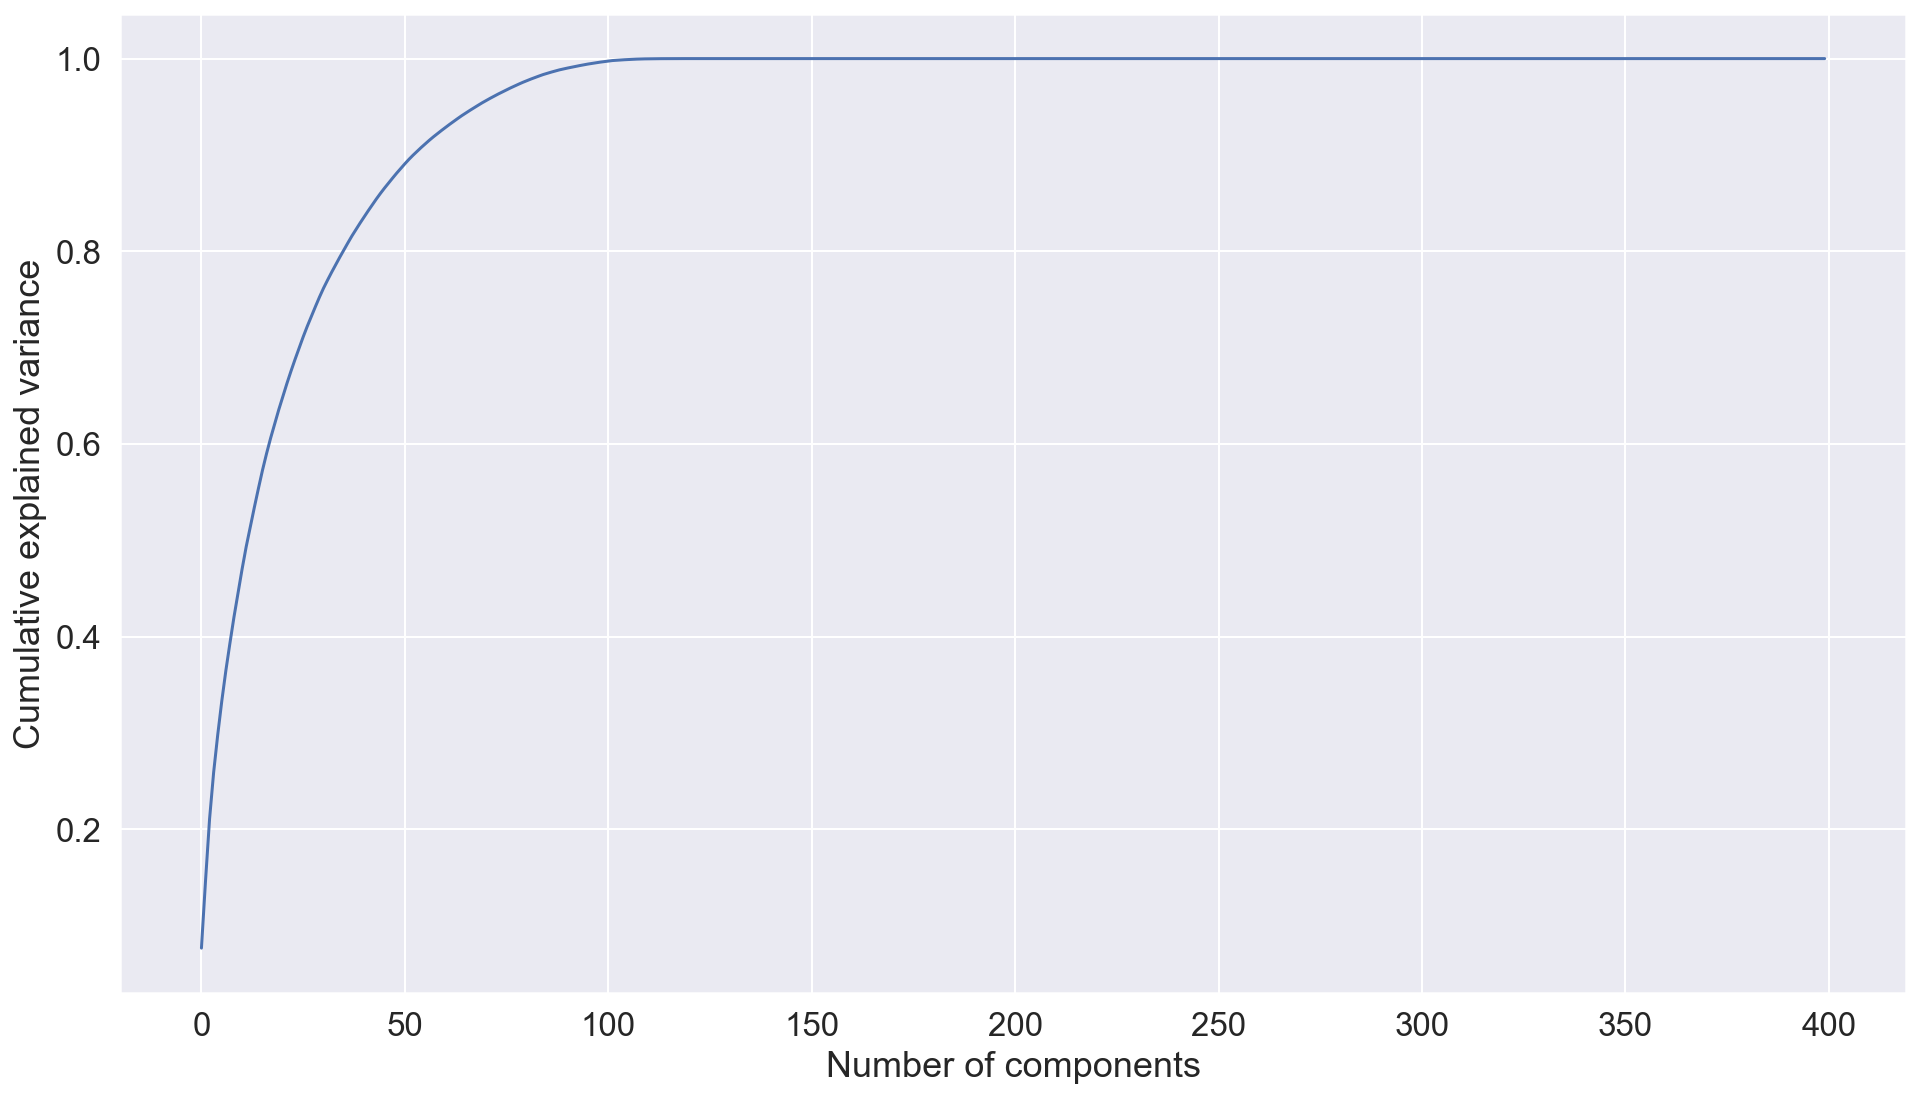

In [829]:
# Plot cumulative explained variance vs. number of components for original

import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd_original_res.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

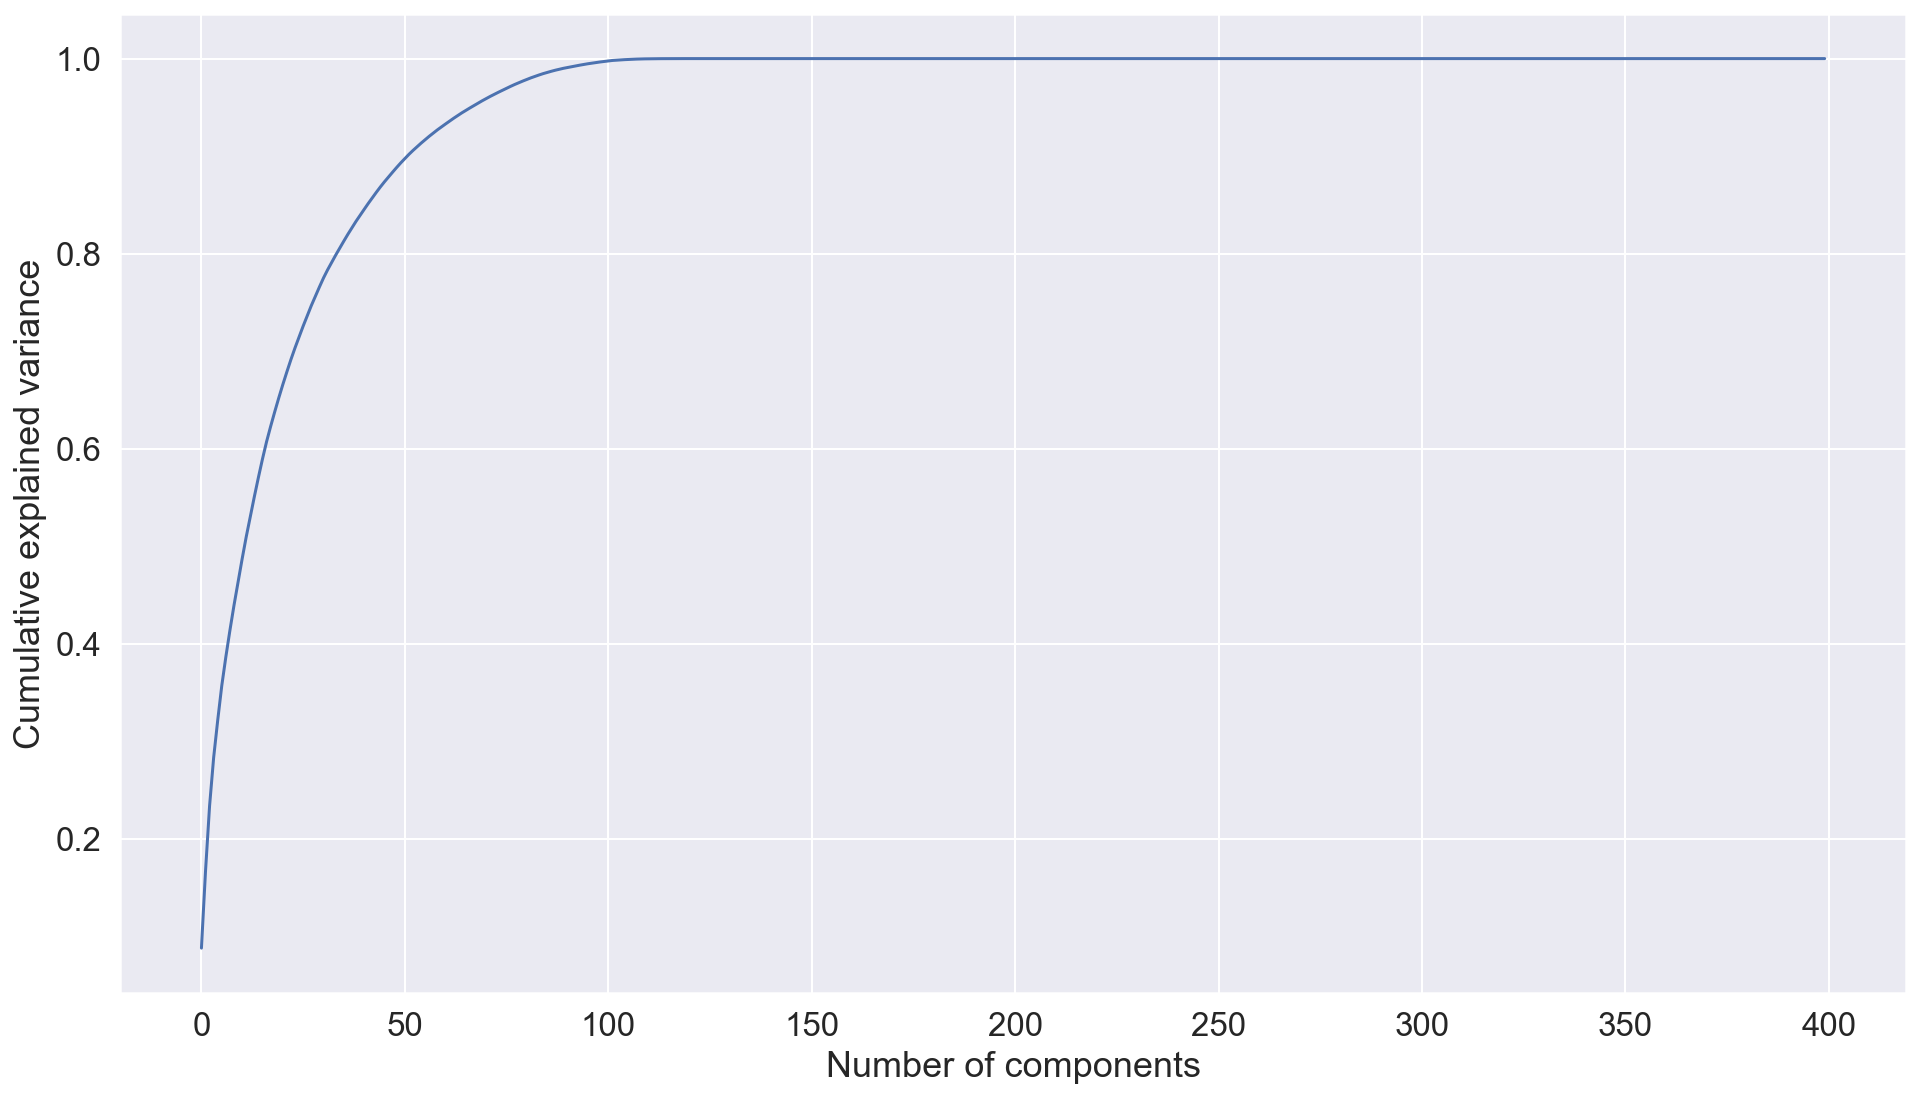

In [428]:
# Plot cumulative explained variance vs. number of components for train

import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd_train_res.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [414]:
# Check variance explained at 100 components

tsvd_res.explained_variance_ratio_[0:80].sum()

0.9771234523694606

In [519]:
# Transform test set from training

df_tsvd_test = pd.DataFrame(tsvd_res.transform(df_test_feat))

In [64]:
# Add product info back into SVD df results
df7['product']=df6['product']

# Extract OG product info
product_details=df2[['product','brand','use_subcategory','active','price','size','ratings','total_reviews','link']].copy()

# Rename
product_details=product_details.rename(columns={'use_subcategory':'product_type'})

# price per oz
product_details['price_oz']=(product_details['price']/product_details['size']).round(2)

# Merge product deets with SVD results
df8 = product_details.merge(df7, how = 'left', on = 'product')

# drop duplicates
df8=df8.drop_duplicates(subset = ["product"])

# Reset index
df8.reset_index(drop=True)

# arrange df similarly
df8=df8.sort_values('product')
df6=df6.sort_values('product')

# add vit a
df8['vit_a']=df6['vit_a'].values

#df8.head(n=5)

# Old feature engineering

#### MOVE COUNTS TO LATER, AFTER INGREDIENT LENGTH ISSUE FIXED

In [328]:
# Count how many occurences of each ingredient

ingred_cts = df_temp['ingredients'].value_counts().to_frame()

In [329]:
# Turn counts into df and rename columns

ingred_cts = (
    ingred_cts.reset_index() \
    .rename({'index':'ingredient','ingredients':'cts'}, axis = 'columns')
)

In [299]:
ingred_cts.head()

,ingredient,cts
0,,0.080532
1,glycerin,0.021536
2,phenoxyethanol,0.017794
3,butylene glycol,0.012833
4,disodium edta,0.011378


In [32]:
# If active ingredient, paste to other column for text parsing
# df_temp['test'] = np.where(df_temp['ingredients'].str.contains('active')==True,
#                            df_temp['ingredients'],'no_actives')

In [33]:
# If active ingredient, paste to other column for text parsing
# - Make two columns, one for ingredient name, the other for the value
df_temp['active'] = np.where(df_temp['ingredients'].str.contains('active')==True,
                           df_temp['ingredients'],'no_actives')
df_temp['active_value'] = np.where(df_temp['ingredients'].str.contains('active')==True,
                           df_temp['ingredients'],'no_actives')

In [34]:
## Active ingredients
# Remove active ingredient with blanks
df_temp['active']=df_temp['active'].str.replace('.*active.*: |\d*\.*\d*%|\(\d*\.*\d*%\)| \d+\.\d+| \d+| +\(sunscreen\)','').str.strip() #|\d*.*\d*%

# Remove regex error
df_temp['active']=df_temp['active'].str.replace('solar vitis\) and bioactive berry complex','no_actives').str.strip()

# Replace avebenzone
df_temp['active']=df_temp['active'].str.replace('avobenzonem','avobenzone').str.strip()

# Separate clumped actives
df_temp['active']=df_temp['active'].str.replace('avobenzoneoctinoxateoctisalate','no_actives').str.strip() # fix later: avobenzone octinoxate octisalate

In [35]:
## Active ingredient values
# Replace % symbol and remove whitespace
df_temp['active_value']=df_temp['active_value'].str.replace('.*active.*: .* |\(|%\)|\s*%','').str.strip()

# Get rid of non-values
df_temp['active_value']=df_temp['active_value'].str.replace('sunscreen\)|solar vitis\) and bioactive 8 berry complex|acid|no_actives','0').str.strip()

# Correct avobenzone
df_temp['active_value']=df_temp['active_value'].str.replace('active: avobenzonem3.0','3').str.strip()

# Convert to numeric, divide by 100 for proportion, and change NAs to zeros
df_temp['active_value'] = pd.to_numeric(df_temp['active_value'],errors='coerce',downcast='signed').fillna(0)/100

In [36]:
# Label vitamin A 
df_temp['ingredients']=df_temp['ingredients'].str.replace('retinyl palmitate \(vitamin a\)|retinyl palmitate \(vitamin a/vitamine a\)','retinyl palmitate').str.strip()

# Label if present or absent
df_temp['vit_a'] = np.where(df_temp['ingredients'].str.contains('''retinyl palmitate|retinol|bakuchiol|
                                                                        retinyl retinoate|
                                                                        vitamin a \(hpr:hydroxypinacolone retinoate\)'''),
                                'vit_a','no_vit_a')
# Assign value
df_temp['vit_a_value'] = np.where(df_temp['ingredients'].str.contains('''retinyl palmitate|retinol|bakuchiol|
                                                                        retinyl retinoate|
                                                                        vitamin a \(hpr:hydroxypinacolone retinoate\)'''),
                                1,0)

In [37]:
# Create column for presence of ingredient in a product (excluding absences and does not account for all possible ingredients)
df_temp['ingred_value'] = 1
df_temp['skintype_value'] = 1 
df_temp['producttype_value'] = 1 

In [158]:
## Remove common or non-important ingredient rows and ingredient entry errors
# Remove rows that contain the following words or characters
df_temp = df_temp[~df_temp['ingredients'].str.contains('''phenoxyethanol|fragrance|disodium edta|citric acid|
                                                       |xanthan gum|sodium hydroxide|potassium sorbate|sodium benzoate|
                                                       |linalool|carbomer|limonene|sodium chloride|citronellol|
                                                       |geraniol|methylparaben|potassium hydroxide|bht|
                                                       |tetrasodium edta|propylparaben|benzoic acid|trisodium ethylenediamine disuccinate|
                                                       |ethylparaben|\+ plant derived / origine vtale|
                                                       |methylisothiazolinone|opens in a new windo|ulta\.com/coupons for details|
                                                       |see|eugenol|essential oi|glycerin|butylene glycol|caprylyl glycol|
                                                       |ci|ptfe|xantham gum|> denotes organically soure|ethylhexylglycerin|
                                                       |red|green|yellow|blue|organic sucrose \(brown sugar|dimethicone|
                                                       |contains less than 0\.3% thc|f\.i\.l\.# b172461/1|
                                                       |denotes certified organic ingredien|de lagriculture biologique|
                                                       |d227948/1|95% naturally derived naturellement|etc|
                                                       |soothing complex: \[sodium hyaluronate|\+plant derived/origine végétale|
                                                       |lifting phase|phenoxyethnaol|denotes organically sourced|\++|
                                                       |firming phase|with minerals|98% organic of total|\[v2968a|hotheyver|
                                                       |\[v2899a|fd \& c color| denotes organically sourced|5%|\[v2922a|
                                                       |\[v3147a\]|flavor|\(solvent\)|naturally-derived|organi|refer to the product packaging|
                                                       |depending on the location and timing of purchase|napiers moisture formul|
                                                       |xanthangum|xanathan gum|xanthum gum|the most bioavailable form of vitamin c|
                                                       |when skin is overwhelmed due to stress|for the 1st time from vichy|
                                                       |the skin¿s defenses can become overworked|violet|laureth¿4|phenoxyrthanol|
                                                       |67%|lait de chèvre\)|\[v2898a|\[v3059a\]|\[v2968a|the carefully selected|
                                                       |xenthan gum|variations in color|95% naturally derived/dérivé naturellement|
                                                       |de l¿agriculture biologique|# b201629/1''')]
# replace
#'glycerin+|'

In [1918]:
ingred_cts = df_test['ingredients'].value_counts()
ingred_cts

tocopherol                                            542
tocopheryl acetate                                    423
propanediol                                           385
cetearyl alcohol                                      384
glyceryl stearate                                     380
caprylic/capric triglyceride                          367
polysorbate 20                                        336
propylene glycol                                      280
chlorphenesin                                         272
panthenol                                             263
cetyl alcohol                                         259
squalane                                              257
allantoin                                             242
peg-100 stearate                                      235
pentylene glycol                                      235
acrylates/c10-30 alkyl acrylate crosspolymer          228
silica                                                207
hexylene glyco

In [1789]:
ingred_cts = df2['ingredients'].value_counts()
ingred_cts

water                                                 1828
glycerin                                              1446
phenoxyethanol                                        1172
butylene glycol                                        851
fragrance                                              781
disodium edta                                          738
citric acid                                            675
xanthan gum                                            672
caprylyl glycol                                        665
ethylhexylglycerin                                     629
sodium hyaluronate                                     628
dimethicone                                            622
tocopherol                                             542
sodium hydroxide                                       514
potassium sorbate                                      486
sodium benzoate                                        450
tocopheryl acetate                                     4

In [1947]:
# Print barplot of counts of each ingredient
import matplotlib.pyplot as plt
#plt.hist(ingred_cts)
#plt.show()

df_test = df_temp['ingredients'].copy().unique()
df_test2 = df_temp['ingredients'].value_counts()
#df_test.columns
#df_test.sort_values('ingred_cts', ascending=False).plot.bar()

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
# Remove rows with 1 by itself, watch out for removing ceramide 1!
# Replace 2-hexanediol w/ 1,2-hexanediol
# Counts of particular types of ingredients, e.g. extracts, acids, parabens
# heuristic for AHA: glycolic acid, BHA: salicylic acid; malic acid?salicylic acid (0.5%); active: salicylic acid (1.0%)
# What about these? red 40 (ci 16035), yellow 5 (ci 19140)., fd&amp;c yellow no, 5 (ci 19140).
# Vitamin C: ascorbyl palmitate, ascorbic acid
# Vitamin A: retinyl palmitate
# iron oxides (ci 77492).
# active ingredient: salicylic acid (1.51%) : if else, paste to other columns
# other ingredients: water (aqua) : str replace other ingredients
# alcohol denat : str replace with alcohol?

In [ ]:
# Code from Jane
# import string

# gamename.translate(str.maketrans('','',string.punctuation))

## Pivot data and merge

In [38]:
# Move cleaning data 
df2 = df_temp.copy() 

In [ ]:
df2.shape

In [ ]:
df2['ingredients'].unique()[:100]

### Ordinal encoding for ingredients

In [39]:
# Add sequence for each ingredient in product
df2['ingred_order'] = df2.groupby('product')['ingred_value'].rank(method="first", ascending=True)

# Get max value of sequence and store in separate df
df2temp = df2.groupby('product')['ingred_order'].max().reset_index()

# Plus 1 so that last ingredient is 1 when take difference of max and ingredient order
# Otherwise zero will indicate that last ingredient isn't present
df2temp['ingred_order'] = df2temp['ingred_order']+1
df2temp=df2temp.rename(columns={"ingred_order":"ingred_ordinal_max"})

# Merge with original DF
df2=pd.merge(df2,df2temp,on='product')

# Take difference of ordinal max from ingredient order to get ordinal values for ingredients
df2['ingred_ordinal'] = df2["ingred_ordinal_max"] - df2["ingred_order"]

# Scale by the ordinal max so products with different numbers of ingredients are on the same scale
# minus 1 because added 1 before so last ingredient would not be zero
df2['ingred_ordinal_sc'] = df2['ingred_ordinal']/(df2["ingred_ordinal_max"]-1)

In [40]:
#df2[df2['brand']=='SUNDAY RILEY']

In [41]:
# Drop page
df2.drop(columns=['page'], inplace=True)

### Pivot ingredients long to wide

In [42]:
df3 = df2.pivot_table(index=['product','skintype','skintype_value','use_subcategory','producttype_value','active',
                             'active_value'],
                    columns='ingredients',
                    values='ingred_ordinal_sc',
                     aggfunc='max',
                     fill_value=0)
# Put index values back as columns
df3.reset_index(inplace=True)

In [164]:
df3.head()

ingredients,product,skintype,skintype_value,use_subcategory,producttype_value,active,active_value,(component of witch hazel,(rosewood) oil,(sodium lactate),...,zinc oxide (mineral),zinc oxide 10.5 %,zinc oxide 4.8%,zinc oxide 5.1%,zinc oxide 6.3%,zinc palmitoyl nonapeptide-14,zinc pca,zinc sulfate,~ ecocert,¿plant derived / origine végétale
0,''Buffet'',dry,1,face serum,1,no_actives,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,''Buffet'',oily,1,face serum,1,no_actives,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,''Buffet'' + Copper Peptides 1%,dry,1,face serum,1,no_actives,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,''Buffet'' + Copper Peptides 1%,oily,1,face serum,1,no_actives,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,+Retinol Vita C Power Serum Firming + Brighten...,dry,1,face serum,1,no_actives,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


NameError: name 'df3' is not defined

### Pivot skintype long to wide

In [43]:
# Pivot wider based on skintype
df4 = df3.pivot_table(index='product',
                    columns='skintype',
                    values='skintype_value',
                     aggfunc='max',
                     fill_value=0)

# Put index values back as columns
df4.reset_index(inplace=True)

In [44]:
# merge df for one hot encoding for skintypes
df5=pd.merge(df3,df4,on='product')

# Get rid of skintype and skintype_value columns now that they're one hot encoded
df5.drop(columns=['skintype','skintype_value'], inplace=True)

### Pivot wider based on use_subcategory

In [45]:
df4_1 = df3.pivot_table(index='product',
                    columns='use_subcategory',
                    values='producttype_value',
                     aggfunc='max',
                     fill_value=0)

# Put index values back as columns
df4_1.reset_index(inplace=True)

In [46]:
# merge df for one hot encoding for skintypes
df5=pd.merge(df5,df4_1,on='product')

# Get rid of skintype and skintype_value columns now that they're one hot encoded
df5.drop(columns=['use_subcategory','producttype_value'], inplace=True)
#df5.head()

### Pivot wider based on active

In [47]:
# Increase weighting of the active value by adding a constant of 50 plus the active amount
df2['active_value'] = np.where(df2['active_value'] > 0,
                           df2['active_value']+100,df2['active_value'])

In [170]:
df2['active_value'].describe()

count    29872.000000
mean         0.224392
std          4.732845
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.200000
Name: active_value, dtype: float64

In [48]:
df4_2 = df2.pivot_table(index='product',
                    columns='active',
                    values='active_value',
                     aggfunc='max',
                     fill_value=0)

# Put index values back as columns
df4_2.reset_index(inplace=True)

In [172]:
df2.head() 

,use_category,use_subcategory,skintype,brand,product,size,price,details,ingredients,ratings,...,active_value,vit_a,vit_a_value,ingred_value,skintype_value,producttype_value,ingred_order,ingred_ordinal_max,ingred_ordinal,ingred_ordinal_sc
0,cleanser,face wash,oily,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,water,4.5,...,0.0,no_vit_a,0,1,1,1,1.0,39.0,38.0,1.000000
1,cleanser,face wash,oily,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates/steareth-20 methacrylate copolymer,4.5,...,0.0,no_vit_a,0,1,1,1,2.0,39.0,37.0,0.973684
2,cleanser,face wash,oily,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates copolymer,4.5,...,0.0,no_vit_a,0,1,1,1,3.0,39.0,36.0,0.947368
3,cleanser,face wash,oily,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,decyl glucoside,4.5,...,0.0,no_vit_a,0,1,1,1,4.0,39.0,35.0,0.921053
4,cleanser,face wash,oily,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,disodium cocoamphodiacetate,4.5,...,0.0,no_vit_a,0,1,1,1,5.0,39.0,34.0,0.894737


In [49]:
# merge df for one hot encoding for actives
df5=pd.merge(df5,df4_2,on='product')

In [50]:
# Get rid of skintype and skintype_value columns now that they're one hot encoded
df5.drop(columns=['active','active_value'], inplace=True)
#df5.head()

In [51]:
# Extract distinct rows since no longer need product duplicates
df5=df5.drop_duplicates(subset = ["product"])
#df5.shape

In [176]:
df5.head()

,product,(component of witch hazel,(rosewood) oil,(sodium lactate),2 hexanediol,2- hexanediol,2-h exanediol,3 propanediol,3-glyceryl ascorbate,4-dicarboxylate,...,face wash,toner,toothpaste,avobenzone,homosalate_y,no_actives,octinoxate,sulfur_y,titanium dioxide_y,zinc oxide_y
0,''Buffet'',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
6,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
8,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0


### Pivot wider vitamin A

In [52]:
df4_3 = df2.pivot_table(index='product',
                    columns='vit_a',
                    values='vit_a_value',
                     aggfunc='max',
                     fill_value=0)

# Put index values back as columns
df4_3.reset_index(inplace=True)

In [178]:
df4_3.head() 

vit_a,product,no_vit_a,vit_a
0,''Buffet'',0,0
1,''Buffet'' + Copper Peptides 1%,0,0
2,+Retinol Vita C Power Serum Firming + Brighten...,0,1
3,+Retinol Vitamin C Moisturizer,0,1
4,1000 Roses Cleansing Foam,0,0


In [53]:
# merge df for one hot encoding for actives
df5=pd.merge(df5,df4_3,on='product')

In [180]:
df5.head()

,product,(component of witch hazel,(rosewood) oil,(sodium lactate),2 hexanediol,2- hexanediol,2-h exanediol,3 propanediol,3-glyceryl ascorbate,4-dicarboxylate,...,toothpaste,avobenzone,homosalate_y,no_actives,octinoxate,sulfur_y,titanium dioxide_y,zinc oxide_y,no_vit_a,vit_a
0,''Buffet'',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
1,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0
2,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,1
3,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,1
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0


In [54]:
# Get rid of skintype and skintype_value columns now that they're one hot encoded
df5.drop(columns=['no_vit_a'], inplace=True)
#df5.head()

In [182]:
df5['vit_a'].values

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Additional scaling

In [55]:
# Add total ingredients column
tempdf = df2[['ingred_ordinal_max', 'product']]
tempdf = tempdf.rename(columns={'ingred_ordinal_max':'total_ingred'})
# Remove extra 1 added for ordinal encoding
tempdf['total_ingred']=tempdf['total_ingred']-1
# Remove duplicate rows
tempdf=tempdf.drop_duplicates(subset = ["product"])
#tempdf.head()
# Merge df
df6 = df5.merge(tempdf, how = 'left', on = 'product')
df6.head()

,product,# b201629/1,(component of witch hazel,(rosewood) oil,(sodium lactate),(solvent),+ plant derived / origine végétale,+contains soy,+napiers original formul,+plant derived/origine végétale,...,benzoyl peroxide,homosalate_y,no_actives,octinoxate,salicylic acid_y,sulfur_y,titanium dioxide_y,zinc oxide_y,vit_a,total_ingred
0,''Buffet'',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100.0
1,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,96.0
2,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,72.0
3,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,123.0
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,23.0


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df6[['total_ingred_sc']] = scaler.fit_transform(df6[['total_ingred']])
#df6.head()

In [1597]:
df6.head()

,product,aloe barbadensis (aloe vera) leaf juice,certified organic ingredien,cymbopogon schoenanthus (lemongrass) oil,denotes certified organic ingredient,denotes organically sourced,essential oi,limonene,organic sucrose (brown sugar,plant derived,...,benzoyl peroxide,homosalate_y,no_actives,octinoxate,salicylic acid_y,sulfur_y,titanium dioxide_y,zinc oxide_y,total_ingred,total_ingred_sc
0,''Buffet'',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.280802
1,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.269341
2,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.200573
3,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.346705
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.060172


## SVD

In [1512]:
#df6.columns[2950:]

Index(['vinyl dimethicone/methicone silsesquioxane',
       'vinylidene chloride copolymer', 'violet 2', 'violet 2 (ci 60730)',
       'violet 2)', 'vitamin a (hpr:hydroxypinacolone retinoate)',
       'vitamin b5 (panthenol)', 'vitamin c',
       'vitamin c (100% l-ascorbic acid)',
       'vitamin c (sodium ascorbyl phosphate)', 'vitamin c/ascorbic acid',
       'vitamin e (tocopherol)', 'vitamin e (tocopheryl)',
       'vitamin e (tocotrienol)', 'vitas vinifera (grape) seed oil',
       'vitis vinifera (grape seed oil)', 'vitis vinifera (grape) fruit',
       'vitis vinifera (grape) seed oil', 'vitis vinifera (grape) seed oil+',
       'vitis vinifera (grapeseed) oil',
       'vitis vinifera (organic white grape juice)',
       'vitis vinifera (white grape) juice', 'vitis viniferz (grape) seed oil',
       'volcanic ash', 'volcanic soil', 'vp/eicosene copolymer',
       'vp/va copolymer', 'water', 'wheat amino acids',
       'when skin is overwhelmed due to stress',
       'whey prot

In [62]:
## Validation fit for product type

from sklearn.decomposition import TruncatedSVD
#from scipy.sparse import csr_matrix
import seaborn as sns

# Create feature ready df
features = df6.copy().drop(['total_ingred', 'all','face moisturizer','face serum','face wash',
                           'toner','toothpaste'],axis=1).set_index('product')


In [84]:
df6.columns[-30:]

Index(['zinc oxide (mineral)', 'zinc oxide 10.5 %', 'zinc oxide 4.8%',
       'zinc oxide 5.1%', 'zinc oxide 6.3%', 'zinc palmitoyl nonapeptide-14',
       'zinc pca', 'zinc sulfate', '~ ecocert',
       '¿plant derived / origine végétale', 'Unknown', 'all', 'dry', 'normal',
       'oily', 'face moisturizer', 'face serum', 'face wash', 'toner',
       'toothpaste', 'avobenzone', 'homosalate_y', 'no_actives', 'octinoxate',
       'sulfur_y', 'titanium dioxide_y', 'zinc oxide_y', 'vit_a',
       'total_ingred', 'total_ingred_sc'],
      dtype='object')

In [126]:
df6.loc[df6['vit_a'] == 1]

,product,(component of witch hazel,(rosewood) oil,(sodium lactate),2 hexanediol,2- hexanediol,2-h exanediol,3 propanediol,3-glyceryl ascorbate,4-dicarboxylate,...,toothpaste,avobenzone,homosalate_y,no_actives,octinoxate,sulfur_y,titanium dioxide_y,zinc oxide_y,vit_a,total_ingred
2,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,46.0
3,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,81.0
18,A+ High-Dose Retinoid Serum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,34.0
44,Advanced Retinol Concentrated Serum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,52.0
51,Age Reform Hydro-Dynamic Ultimate Moisture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,Vital Vita 12 Calming Ampoule,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,84.0
810,Vital Vita 12 Poresole Ampoule,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,44.0
811,Vital Vita 12 Synergy Ampoule,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,86.0
822,Vitamin C Renewing Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,30.0


In [109]:
df6['vit_a'].values

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
## FIT SVD FOR SPARSE DATA
# Load libraries

from sklearn.decomposition import TruncatedSVD
#from scipy.sparse import csr_matrix
import seaborn as sns

# Create feature ready df
#features = df6.copy().drop(['total_ingred'],axis=1).set_index('product')
# Try removing features that will wash out the important ingredients
features = df6.copy().drop(['total_ingred','total_ingred_sc','no_actives'],axis=1).set_index('product')

In [1971]:
features.shape

(853, 2194)

In [58]:
# Create a TSVD
tsvd = TruncatedSVD(n_components=20)

# Conduct TSVD on sparse matrix
X_sparse_tsvd = tsvd.fit(features).transform(features)
df7 = pd.DataFrame(X_sparse_tsvd)

In [187]:
# Sum of first three components' explained variance ratios
dat_plot = pd.DataFrame(tsvd.explained_variance_ratio_[0:400])
tsvd.explained_variance_ratio_[0:20].sum()

0.987523990357333

In [441]:
# Eigenvalues
tsvd.explained_variance_

array([0.1837389 , 0.36298439, 0.33308637, 0.25325717, 0.21017713,
       0.18003669, 0.15449495, 0.13563904, 0.12890032, 0.12637338,
       0.11109831, 0.10867418, 0.09740543, 0.09671291, 0.09551439,
       0.09303635, 0.08918521, 0.08845115, 0.08529319, 0.08328756,
       0.08136854, 0.07814838, 0.07706576, 0.07507417, 0.07212604,
       0.07175233, 0.07055295, 0.0671992 , 0.06681318, 0.06556072,
       0.06150146, 0.06098436, 0.0601717 , 0.06001009, 0.05839092,
       0.05610916, 0.05579048, 0.0544885 , 0.05276866, 0.05188954,
       0.05089707, 0.04950202, 0.04856195, 0.04819334, 0.04785062,
       0.04656478, 0.04534316, 0.04478381, 0.04449258, 0.04376333,
       0.04280615, 0.04263771, 0.04141139, 0.04066093, 0.0397463 ,
       0.0394692 , 0.03861206, 0.0382935 , 0.03767547, 0.03658265,
       0.03606214, 0.03563213, 0.03526112, 0.03462202, 0.03392248,
       0.03371947, 0.03339821, 0.03280109, 0.03192367, 0.03169268,
       0.03138058, 0.03057876, 0.03052861, 0.02987992, 0.02928

In [ ]:
# Plot 
ax = sns.barplot(x="day", y="tsvd.explained_variance_ratio_[0:2]", data=dat_plot)

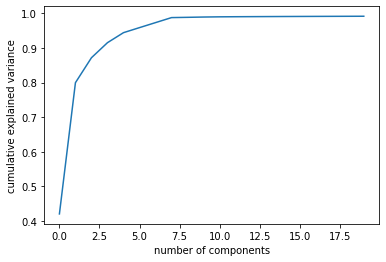

In [59]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [81]:
df7.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,product
0,0.009204,0.011341,0.023269,0.001106,0.009278,0.010914,1.280548,-0.890542,-0.761047,-0.122545,...,0.114051,0.090415,-0.051842,0.050151,0.164309,-0.256390,-0.048726,-0.102896,0.129645,''Buffet''
1,0.009203,0.011328,0.023106,0.001185,0.009275,0.010904,1.269015,-0.896785,-0.755626,-0.141973,...,0.091836,0.091219,-0.059858,0.045809,0.154833,-0.249628,-0.024380,-0.081873,0.128700,''Buffet'' + Copper Peptides 1%
2,0.010524,0.016308,0.034288,-0.006236,0.008147,0.010867,1.504534,-0.736024,-0.919158,-0.257619,...,0.014196,-0.145393,0.047914,0.163364,0.069261,-0.063634,-0.029601,-0.115917,0.068486,+Retinol Vita C Power Serum Firming + Brighten...
3,0.024508,0.048238,0.081195,-0.000768,0.022494,0.010883,2.246672,1.589907,-0.383671,-0.096132,...,-0.055208,0.391547,0.074795,0.367636,0.299469,-0.028914,-0.335573,-0.127272,0.300350,+Retinol Vitamin C Moisturizer
4,0.009194,0.011118,0.025220,0.006961,0.008404,0.010640,1.044953,-0.222914,0.417666,0.170021,...,0.008703,-0.022128,-0.178731,-0.002133,-0.017123,0.000331,0.029022,-0.062398,0.091851,1000 Roses Cleansing Foam


In [64]:
# Add product info back into SVD df results
df7['product']=df6['product']

# Extract OG product info
product_details=df2[['product','brand','use_subcategory','active','price','size','ratings','total_reviews','link']].copy()

# Rename
product_details=product_details.rename(columns={'use_subcategory':'product_type'})

# price per oz
product_details['price_oz']=(product_details['price']/product_details['size']).round(2)

# Merge product deets with SVD results
df8 = product_details.merge(df7, how = 'left', on = 'product')

# drop duplicates
df8=df8.drop_duplicates(subset = ["product"])

# Reset index
df8.reset_index(drop=True)

# arrange df similarly
df8=df8.sort_values('product')
df6=df6.sort_values('product')

# add vit a
df8['vit_a']=df6['vit_a'].values

#df8.head(n=5)

In [139]:
df8.head()

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,41,42,43,44,45,46,47,48,49,vit_a
10434,''Buffet'',The Ordinary,face serum,no_actives,14.80,1.0,4.4,333,https://www.ulta.com/buffet?productId=pimprod2...,14.80,...,0.114051,0.090415,-0.051842,0.050151,0.164309,-0.256390,-0.048726,-0.102896,0.129645,0
8418,''Buffet'' + Copper Peptides 1%,The Ordinary,face serum,no_actives,28.90,1.0,4.3,52,https://www.ulta.com/buffet-copper-peptides-1?...,28.90,...,0.091836,0.091219,-0.059858,0.045809,0.154833,-0.249628,-0.024380,-0.081873,0.128700,0
8372,+Retinol Vita C Power Serum Firming + Brighten...,Kate Somerville,face serum,no_actives,98.00,1.0,4.3,47,https://www.ulta.com/retinol-vita-c-power-seru...,98.00,...,0.014196,-0.145393,0.047914,0.163364,0.069261,-0.063634,-0.029601,-0.115917,0.068486,1
20702,+Retinol Vitamin C Moisturizer,Kate Somerville,face moisturizer,no_actives,90.00,1.7,3.7,10,https://www.ulta.com/retinol-vitamin-c-moistur...,52.94,...,-0.055208,0.391547,0.074795,0.367636,0.299469,-0.028914,-0.335573,-0.127272,0.300350,1
6092,1000 Roses Cleansing Foam,Andalou Naturals,face wash,no_actives,12.99,0.6,4.8,10,https://www.ulta.com/1000-roses-cleansing-foam...,21.65,...,0.008703,-0.022128,-0.178731,-0.002133,-0.017123,0.000331,0.029022,-0.062398,0.091851,0


In [135]:
df6.head()#sort_values('product')

,product,(component of witch hazel,(rosewood) oil,(sodium lactate),2 hexanediol,2- hexanediol,2-h exanediol,3 propanediol,3-glyceryl ascorbate,4-dicarboxylate,...,toothpaste,avobenzone,homosalate_y,no_actives,octinoxate,sulfur_y,titanium dioxide_y,zinc oxide_y,vit_a,total_ingred
0,''Buffet'',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,60.0
1,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,58.0
2,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,46.0
3,+Retinol Vitamin C Moisturizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,81.0
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,14.0


In [121]:
df6['vit_a'].dtype

dtype('int64')

In [128]:
df8['vit_a']

0      0
36     0
63     1
105    1
126    0
Name: vit_a, dtype: int64

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,41,42,43,44,45,46,47,48,49,vit_a
0,The Microdelivery Exfoliating Facial Wash,Philosophy,face wash,no_actives,29.00,8.00,4.5,812,https://www.ulta.com/microdelivery-exfoliating...,3.62,...,0.025182,-0.027935,0.048542,0.168888,-0.064342,-0.029877,0.023201,-0.050958,-0.074378,0
1,AHA/BHA Exfoliating Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,267,https://www.ulta.com/ahabha-exfoliating-cleans...,5.93,...,0.145476,0.023719,0.078348,-0.187813,0.074210,0.173912,0.006308,0.105570,0.038466,0
2,Hydrating Facial Cleanser,CeraVe,face wash,no_actives,13.49,8.00,4.2,700,https://www.ulta.com/hydrating-facial-cleanser...,1.69,...,0.134936,-0.012049,0.238888,-0.189581,-0.185041,-0.154400,0.117378,-0.028735,0.241734,1
3,Anti-Aging Cleansing Gel,Peter Thomas Roth,face wash,no_actives,39.00,8.50,4.5,330,https://www.ulta.com/anti-aging-cleansing-gel?...,4.59,...,0.125236,0.269273,0.142161,-0.001903,0.021177,0.108418,-0.010157,-0.007142,0.047504,1
4,Essential-C Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,272,https://www.ulta.com/essential-c-cleanser?prod...,5.93,...,0.097427,0.082206,0.236783,-0.321999,-0.282681,0.055476,-0.209665,0.014304,-0.161765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,Antiplaque & Whitening Toothpaste Peppermint,Tom's of Maine,toothpaste,no_actives,4.69,5.50,4.7,40,https://www.walgreens.com/store/c/tom's-of-mai...,0.85,...,0.236100,0.034250,-0.077789,0.038679,0.254285,0.001381,0.121588,0.084932,0.046293,0
849,Anticavity Fluoride Toothpaste with Whitening ...,Colgate MaxFresh,toothpaste,no_actives,3.49,6.00,4.7,71,https://www.walgreens.com/store/c/colgate-maxf...,0.58,...,0.288956,0.129749,-0.478267,0.129268,0.412880,0.080882,0.295295,-0.081433,0.013384,0
850,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,...,0.060481,-0.257833,-0.030133,0.167019,-0.003906,0.109727,0.090280,0.031370,-0.071883,0
851,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,...,0.255389,-0.131660,-0.290169,0.536320,0.232750,0.144092,0.310105,0.207430,0.222960,0


## Multidimensional Scaling (MDS)

In [1645]:
from sklearn.manifold import MDS

# Create feature ready df
features = df6.copy().drop(['total_ingred'],axis=1).set_index('product')

In [1646]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(features)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

ValueError: array must be 2-dimensional and square. shape = (868, 3071)

## Isomap

In [1647]:
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(features)
manifold_2Da = iso.transform(features)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
manifold_2D

In [1648]:
manifold_2D

,Component 1,Component 2
0,-4.608253,-0.258623
1,-4.582941,-0.255350
2,-4.276795,-0.455676
3,0.238785,1.949260
4,-0.147978,-4.159920
5,-0.649284,0.283176
6,-4.211385,-0.228256
7,3.274034,-3.806132
8,-0.285016,3.438799
9,5.948327,3.685808


## TSNE

In [1667]:
from sklearn.manifold import TSNE
import seaborn as sns
from bioinfokit.visuz import cluster

In [1650]:
df7.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,product
0,1.410971,-0.996808,-0.881610,-0.158637,0.139026,0.081694,0.228870,-0.074884,-0.284180,0.318604,...,-0.033571,-0.141965,0.028490,-0.048409,-0.007428,-0.133777,0.013843,0.005667,-0.054214,''Buffet''
1,1.385511,-1.007105,-0.874613,-0.177734,0.133217,0.060337,0.211541,-0.087430,-0.267193,0.307600,...,-0.033012,-0.135713,0.017977,-0.046198,-0.005709,-0.132480,0.020181,0.007910,-0.044555,''Buffet'' + Copper Peptides 1%
2,1.397458,-0.824805,-0.932348,-0.291046,0.177248,-0.307962,0.016695,0.192619,0.275030,-0.059395,...,0.079578,-0.048893,-0.036362,-0.036613,-0.075739,0.072118,-0.048611,0.062453,0.029071,+Retinol Vita C Power Serum Firming + Brighten...
3,2.976624,1.305337,0.070063,-0.417562,-0.575400,-0.686137,0.161238,0.568390,0.812400,-0.117759,...,0.048403,-0.247343,-0.018102,0.032433,-0.226699,0.166109,-0.116106,0.011479,-0.005191,+Retinol Vitamin C Moisturizer
4,1.194567,-0.516329,0.456397,-0.077699,-0.611891,0.080088,-0.326608,0.155323,-0.671238,0.491782,...,0.074746,0.021783,0.128623,0.032389,-0.075601,-0.060897,-0.107591,0.025292,0.020983,1000 Roses Cleansing Foam


In [1690]:
# Use df7 that is directly from SVD and doesn't have product added to it
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(df7)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 868 samples in 0.005s...
[t-SNE] Computed neighbors for 868 samples in 0.370s...
[t-SNE] Computed conditional probabilities for sample 868 / 868
[t-SNE] Mean sigma: 0.127644
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.894241
[t-SNE] KL divergence after 300 iterations: 2.041416


In [1658]:
features_plot = features.copy()

In [1691]:
cluster.tsneplot(score=tsne_results)

In [88]:
## PUT TSNE RESULTS IN DF
df_tsne = pd.DataFrame(tsne_results)

# Add product info back into TSNE df results
df_tsne['product']=df6['product']
# Extract OG product info
product_details=df2[['product','brand','use_subcategory','active','price','size','ratings','total_reviews','link']].copy()
# Rename
product_details=product_details.rename(columns={'use_subcategory':'product_type'})
# price per oz
product_details['price_oz']=(product_details['price']/product_details['size']).round(2)
# Merge product deets with SVD results
df_tsne = product_details.merge(df_tsne, how = 'left', on = 'product')
# drop duplicates
df_tsne=df_tsne.drop_duplicates(subset = ["product"])

NameError: name 'tsne_results' is not defined

In [1696]:
# Export data for analysis
df_tsne.to_csv(f"{rpath}/data/data_clean.csv",index=True)

In [1664]:
color_class = df['class'].to_numpy()
cluster.tsneplot(score=tsne_score, colorlist=color_class, legendpos='upper right', legendanchor=(1.15, 1) )

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1152x720 with 1 Axes>

## Check and export data

In [83]:
df8.loc[df8['brand']=='SUNDAY RILEY']

,product,brand,product_type,active,vit_a,price,size,ratings,total_reviews,link,...,40,41,42,43,44,45,46,47,48,49
6367,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,no_vit_a,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,...,-0.253345,-0.035454,-0.094405,0.064425,0.324565,0.043244,-0.400422,0.019717,0.228416,-0.133120
7112,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,no_vit_a,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,...,-0.112291,0.476284,-0.028652,0.285159,-0.344243,0.007519,-0.441610,0.499462,0.055843,0.122928
27215,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,no_vit_a,85.0,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,...,-0.265798,0.060481,-0.257833,-0.030133,0.167019,-0.003906,0.109727,0.090280,0.031370,-0.071883
27230,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,no_vit_a,85.0,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,...,-0.456678,0.255389,-0.131660,-0.290169,0.536320,0.232750,0.144092,0.310105,0.207430,0.222960
27264,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,no_actives,no_vit_a,85.0,1.00,3.8,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,...,-0.280045,0.117114,-0.435442,0.297068,-0.076259,-0.020235,0.105229,0.204835,0.017632,-0.068019


In [124]:
df8

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,41,42,43,44,45,46,47,48,49,vit_a
0,The Microdelivery Exfoliating Facial Wash,Philosophy,face wash,no_actives,29.00,8.00,4.5,812,https://www.ulta.com/microdelivery-exfoliating...,3.62,...,0.025182,-0.027935,0.048542,0.168888,-0.064342,-0.029877,0.023201,-0.050958,-0.074378,0
36,AHA/BHA Exfoliating Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,267,https://www.ulta.com/ahabha-exfoliating-cleans...,5.93,...,0.145476,0.023719,0.078348,-0.187813,0.074210,0.173912,0.006308,0.105570,0.038466,0
63,Hydrating Facial Cleanser,CeraVe,face wash,no_actives,13.49,8.00,4.2,700,https://www.ulta.com/hydrating-facial-cleanser...,1.69,...,0.134936,-0.012049,0.238888,-0.189581,-0.185041,-0.154400,0.117378,-0.028735,0.241734,1
105,Anti-Aging Cleansing Gel,Peter Thomas Roth,face wash,no_actives,39.00,8.50,4.5,330,https://www.ulta.com/anti-aging-cleansing-gel?...,4.59,...,0.125236,0.269273,0.142161,-0.001903,0.021177,0.108418,-0.010157,-0.007142,0.047504,1
126,Essential-C Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,272,https://www.ulta.com/essential-c-cleanser?prod...,5.93,...,0.097427,0.082206,0.236783,-0.321999,-0.282681,0.055476,-0.209665,0.014304,-0.161765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199,Antiplaque & Whitening Toothpaste Peppermint,Tom's of Maine,toothpaste,no_actives,4.69,5.50,4.7,40,https://www.walgreens.com/store/c/tom's-of-mai...,0.85,...,0.236100,0.034250,-0.077789,0.038679,0.254285,0.001381,0.121588,0.084932,0.046293,0
27205,Anticavity Fluoride Toothpaste with Whitening ...,Colgate MaxFresh,toothpaste,no_actives,3.49,6.00,4.7,71,https://www.walgreens.com/store/c/colgate-maxf...,0.58,...,0.288956,0.129749,-0.478267,0.129268,0.412880,0.080882,0.295295,-0.081433,0.013384,0
27215,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,...,0.060481,-0.257833,-0.030133,0.167019,-0.003906,0.109727,0.090280,0.031370,-0.071883,0
27230,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,...,0.255389,-0.131660,-0.290169,0.536320,0.232750,0.144092,0.310105,0.207430,0.222960,0


In [61]:
# Export data for analysis
df8.to_csv(f"{rpath}/data/data_clean.csv",index=True)
#df8.shape

In [65]:
# Export data for validation
df8.to_csv(f"{rpath}/data/data_clean_prodtype_valid.csv",index=True)
df8.shape

(880, 31)

In [752]:
df8.loc[df8['product_type']=='toothpaste']

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
17129,Sensitivity Whitening Plus Scope Toothpaste Mi...,Crest,toothpaste,NaN,NaN,4.7,<NA>,https://www.walgreens.com/store/c/crest-sensit...,NaN,0.923008,...,-0.018721,-0.006079,-0.006718,0.030224,-0.000054,-0.000381,-0.047090,0.048847,-0.040650,0.042781
17146,Peppermint Toothpaste Peppermint,Dr. Bronner's,toothpaste,NaN,NaN,4.8,<NA>,https://www.walgreens.com/store/c/dr.-bronner'...,NaN,0.514171,...,-0.016996,0.170271,0.076920,-0.004425,-0.068206,-0.018829,0.191683,-0.044516,0.037729,0.088809
17160,Gentle Mint Fluoride Toothpaste Mint,Biotene,toothpaste,NaN,NaN,3.9,<NA>,https://www.walgreens.com/store/c/biotene-gent...,NaN,0.852685,...,-0.083440,0.013792,0.009967,0.023270,-0.010453,0.063252,0.022849,0.084390,-0.006966,-0.006731
